In [23]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [24]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=LTC&tsym=USD&limit=2000')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [25]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2017-05-28,25.92,21.79,22.83,1600758.66,37736853.79,23.89,direct,
2017-05-29,25.99,23.01,23.89,1019676.88,25039934.60,25.33,direct,
2017-05-30,26.33,23.54,25.33,1156827.30,28996976.43,23.89,direct,
2017-05-31,25.99,23.51,23.89,1021629.99,25232341.83,25.91,direct,
2017-06-01,29.61,25.77,25.91,1823401.75,49800957.20,27.55,direct,
...,...,...,...,...,...,...,...,...
2022-11-14,59.12,53.44,57.32,452922.89,25542577.88,56.60,direct,
2022-11-15,59.47,56.47,56.60,298989.95,17378543.99,57.96,direct,
2022-11-16,60.08,56.69,57.96,322625.37,18672466.24,57.47,direct,


In [26]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-05-28,25.92,21.79,22.83,1600758.66,37736853.79,23.89
2017-05-29,25.99,23.01,23.89,1019676.88,25039934.60,25.33
2017-05-30,26.33,23.54,25.33,1156827.30,28996976.43,23.89
2017-05-31,25.99,23.51,23.89,1021629.99,25232341.83,25.91
2017-06-01,29.61,25.77,25.91,1823401.75,49800957.20,27.55
...,...,...,...,...,...,...
2022-11-14,59.12,53.44,57.32,452922.89,25542577.88,56.60
2022-11-15,59.47,56.47,56.60,298989.95,17378543.99,57.96
2022-11-16,60.08,56.69,57.96,322625.37,18672466.24,57.47


In [27]:

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [28]:
def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [29]:
train, test = train_test_split(df,test_size=0.4)

In [30]:
np.array(train)
np.array(test)

array([[4.92600000e+01, 4.82800000e+01, 4.78600000e+01, 8.31116520e+05,
        4.04729774e+07, 4.87000000e+01],
       [4.95700000e+01, 4.83200000e+01, 4.87000000e+01, 8.38122260e+05,
        4.10835203e+07, 4.90200000e+01],
       [5.11500000e+01, 4.91100000e+01, 4.90200000e+01, 1.12223678e+06,
        5.70662071e+07, 5.08500000e+01],
       ...,
       [6.00800000e+01, 5.66900000e+01, 5.79600000e+01, 3.22625370e+05,
        1.86724662e+07, 5.74700000e+01],
       [6.32000000e+01, 5.69900000e+01, 5.74700000e+01, 5.70565630e+05,
        3.41570332e+07, 6.25400000e+01],
       [6.37900000e+01, 6.16200000e+01, 6.25400000e+01, 2.05004150e+05,
        1.28702492e+07, 6.28500000e+01]])

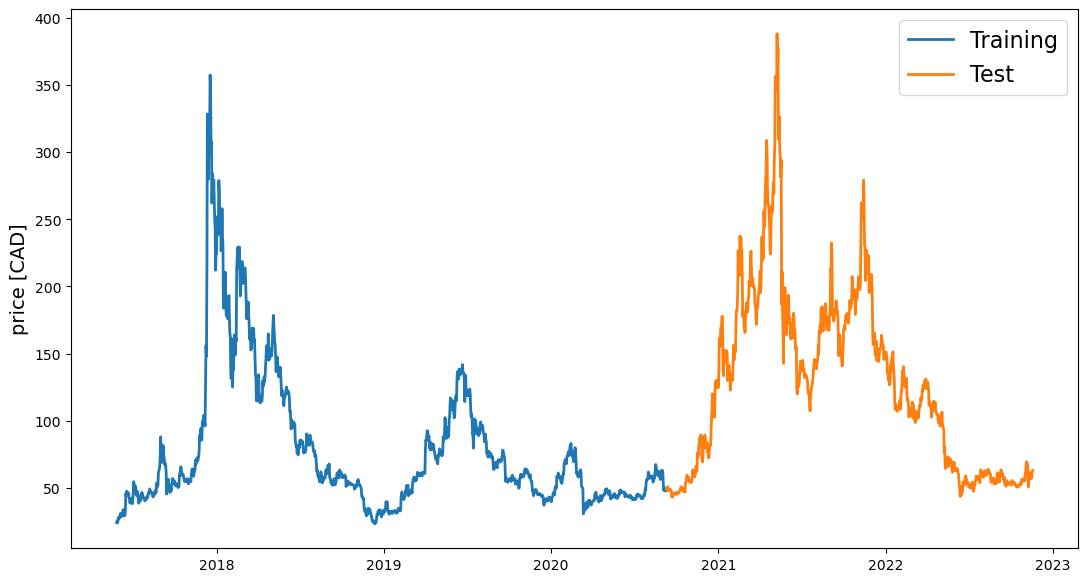

In [31]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [32]:
print(train)
print(test)

             high    low   open  volumefrom     volumeto  close
time                                                           
2017-05-28  25.92  21.79  22.83  1600758.66  37736853.79  23.89
2017-05-29  25.99  23.01  23.89  1019676.88  25039934.60  25.33
2017-05-30  26.33  23.54  25.33  1156827.30  28996976.43  23.89
2017-05-31  25.99  23.51  23.89  1021629.99  25232341.83  25.91
2017-06-01  29.61  25.77  25.91  1823401.75  49800957.20  27.55
...           ...    ...    ...         ...          ...    ...
2020-09-05  51.30  45.46  50.48   632360.78  30550877.38  47.77
2020-09-06  49.05  47.41  47.80   716360.62  34347134.19  47.95
2020-09-07  49.56  47.43  47.95   902712.61  44101419.35  48.85
2020-09-08  48.32  46.99  48.85   889953.07  42230239.88  47.45
2020-09-09  48.38  47.68  47.45   903340.42  43234585.37  47.86

[1201 rows x 6 columns]
             high    low   open  volumefrom     volumeto  close
time                                                           
2020-09-10  49.

In [33]:

def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [34]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [35]:

def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [36]:

def build_lstm_model(input_data, output_size, neurons=150, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [37]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 150
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [38]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [39]:
#Early stopping using callbacks
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=4)

In [40]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks=[es])

Epoch 1/40
38/38 [==============================] - 3s 25ms/step - loss: 0.0156 - val_loss: 0.0065
Epoch 2/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0061
Epoch 3/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0087 - val_loss: 0.0059
Epoch 4/40
38/38 [==============================] - 0s 6ms/step - loss: 0.0086 - val_loss: 0.0046
Epoch 5/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0083 - val_loss: 0.0047
Epoch 6/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0071 - val_loss: 0.0044
Epoch 7/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0040
Epoch 8/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0069 - val_loss: 0.0038
Epoch 9/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0065 - val_loss: 0.0038
Epoch 10/40
38/38 [==============================] - 0s 7ms/step - loss: 0.0063 - val_loss: 0.0037
Epoch 11/40
38/38 

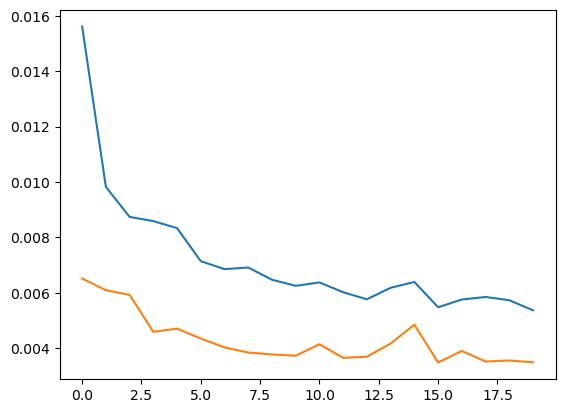

In [41]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [42]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
# print(preds)
mean_absolute_error(preds, y_test)

25/25 [==============================] - 0s 1ms/step


0.04340100387207392

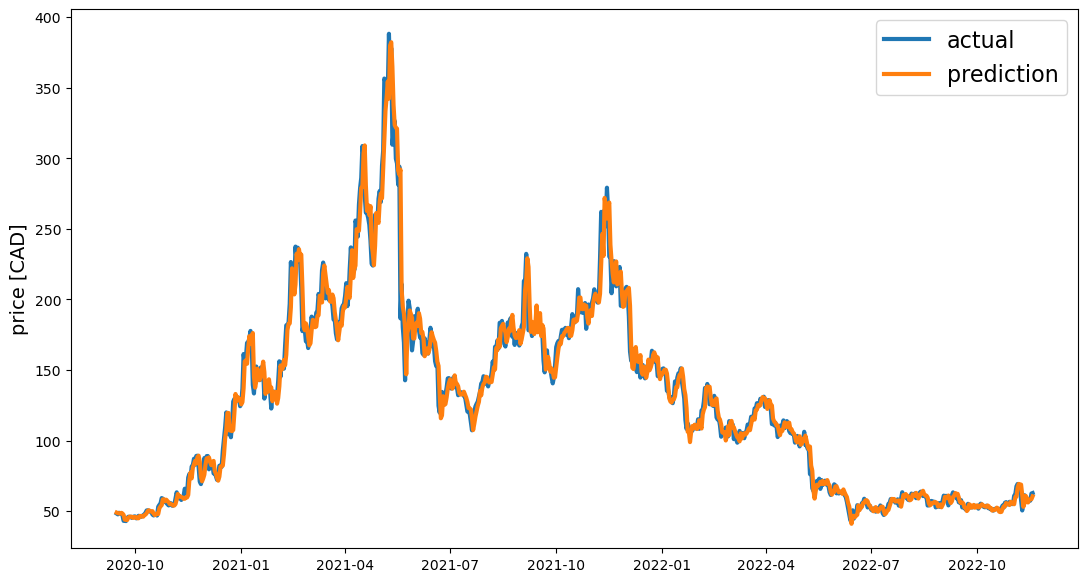

In [43]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [44]:
model.save('LTCmodel.hdf5')